---
>「私たちがここにいるのには理由があります。\
>松明を掲げて、暗闇の中にいる人々を導く役割があると信じています」\
>ウーピー・ゴールドバーグ
---

# PyTorch

PyTorch は科学技術計算向けパッケージであり、
- GPUを使った高速計算が可能
  - 普通やらないがNumPyの代わりに使える
  - NumPyをGPU付きで使いたいならCuPyがある\
    PyTorchよりも先に登場したPFNのChainerはCuPyを使う
- 柔軟かつ高速にディープラーニングプラットフォームを構築可能
である。

https://pytorch.org/ にほぼすべての情報がある。

英語ではあるが、関連するドキュメントが十分かつ分かりやすく準備されている

# PyTorchの基本

PyTorchを用いて学習させる場合、Define-by-Runであることから、Backward演算つまり誤差逆伝搬を行う際には、その前に必ずForward演算つまり順伝搬を行う必要がある
- 順伝搬を求める際に、PyTorchの機能であるAutograd(自動微分)を使って逆演算を求めることができるようになっている
- Define-by-Runであることから、例えばif文で分岐しようが、混ぜようが、分岐しようが、逆伝搬の演算、つまり最適化が可能である

## PyTorchプログラムの形

基本的にPyTorchを用いた学習プログラムは次のスタイルになる
1. データの準備
  - データローダを設定する
  - データの準備と学習モデルに入力する前準備を行う
  - データ拡張(データ数が少ない場合、データを加工して数を増やす手法)などもここで行う
  - 実はこの部分の設計が実際の現場では最も厄介であり、センスが問われる場所でもある
2. モデルの定義
- DNNのネットワークの定義を行う
  - PyTorchのtorch.nnにある関数やPyTorchの算術関数などを利用する
  - 逆伝搬は自動的に計算されるため、順伝搬のみ記述すればよい

  ```
  class myModel(nn.Module):
    def __init__(self, 必要に応じて初期設定):
      super(myModel, self).__init__()
      利用するnnクラスの関数の定義など
    def forward(self, ...):
      順方向計算手順の記述
  ```
3. さまざまな初期化とハイパーパラメータの設定
- 次の必須となる設定を行う
  - モデルの定義で記述したネットワークをインスタンス化する
  - SGDなどの最適化アルゴリズムを指定する
  - 損失関数(ロス関数、誤差関数)を指定する

  ```
  model = myModel()
  optimizer = 最適化アルゴリズム
  criterion = ロス関数
  ```
4. 学習アルゴリズム記述
- 一般に最も実行時間に影響する部分であり、DNN設計の本質的部分
- 以下の処理が必須となる
  - for文によりエポック(データセットを一巡すること)を繰り返し実行する
    - さらにその中にミニバッチ処理のループを配置するのが普通
  - データローダから入力値とその入力値に対する正解ラベルなどのターゲット値を取り出す
  - 取り出した入力をモデルに入力して推定値を得る
  - 推定値とターゲット値から、誤差を求める
  - backward()を呼び出す前に勾配を初期化する
    - PyTorchは逆伝搬で勾配を計算する際、以前に計算した勾配がある場合はそれに加算するように設計されており、`今回の勾配 = 前回計算した勾配 + 今回計算した勾配`となる
    - この仕様はRNNなどでは有用となる場合があるが、そうでない場合は0で初期化する必要がある
  - 逆伝搬を求める
  - 最適化する
- さらに、エポックのループ内で過学習を判定するために、学習に用いない検証データを用いた精度評価を含む学習の途中結果の表示や確認、保存、途中モデル重みなどを保存する処理、場合によっては学習率の調整などの処理も含まれる

  ```
  for epoch in range(繰り返し回数):
    input, target = データローダからの入力と出力データの読み出し
    output = model(input)
    loss = criterion(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  ```
5. 結果の出力

どのようなPyTorchを用いた学習プログラムも、基本的にはこのスタイルに従って記述されている
- 各処理に手順(前後関係)がある以上、スタイルを外れることはほぼない

## PyTorchで線形回帰

PyTorchを用いても線形回帰（Linear Regression）を実現できる

ここでは、Deep Learning実装で用いるのが主たる目的であるPyTorchを使って、線形回帰を実装する

- データとして、手入力の配列データで実装する

- ハイパーパラメータについても、最初に宣言しておくので、値を変えて様々トライしてみるとよいであろう

# PyTorchによる実装例(1) 線形回帰

PyTorchについて学んでいくが、まずはPyTorchを用いた機械学習コードのその実行イメージを掴む
- コードの各行の意味にこだわらず、全体の雰囲気を感じ取ること
  - 英語も文法から入るとつまらないし、自由に使いこなすという観点からは良い方法といえない
  - 使うことを念頭に学ぶのであれば、英語を聞いて話すのと同様、細かいことにこだわらず、コードを見て書けばよい
- 次回のノートブックで基本的なテンソルの扱い方などを学ぶが、そういう内容を深く知らなくてもなんとなくできてしまうという感覚を身につける
  - 自分が何を学んでいるのか、何を学ばないといけないのかを知るには、適度にシンプルな最終形を示すのが一番


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
input_size = 1
output_size = 1
num_epochs = 1000
learning_rate = 0.002

## データセットの準備

ここでは、手入力で適当なデータセットを準備する

- `nn.Linear` に対する入力は、配列の配列であるため `reshape` が必要となる

表示して内容を確認する

- 再びのPyTorchでmodelに食わせるためのreshapeであるが、`reshape(15, 1)`と同じこと

### データセットの準備を行うコード

In [2]:
x_train = np.array([3.3, 4.4, 5.5, 6.71, 6.93, 4.168, 9.779, 6.182, 7.59, 2.167,
                    7.042, 10.791, 5.313, 7.997, 3.1], dtype=np.float32)

y_train = np.array([1.7, 2.76, 2.09, 3.19, 1.694, 1.573, 3.366, 2.596, 2.53, 1.221,
                    2.827, 3.465, 1.65, 2.904, 1.3], dtype=np.float32)
print("ORG:", x_train)
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
print("RESHAPE:",x_train)

ORG: [ 3.3    4.4    5.5    6.71   6.93   4.168  9.779  6.182  7.59   2.167
  7.042 10.791  5.313  7.997  3.1  ]
RESHAPE: [[ 3.3  ]
 [ 4.4  ]
 [ 5.5  ]
 [ 6.71 ]
 [ 6.93 ]
 [ 4.168]
 [ 9.779]
 [ 6.182]
 [ 7.59 ]
 [ 2.167]
 [ 7.042]
 [10.791]
 [ 5.313]
 [ 7.997]
 [ 3.1  ]]


## 学習の手順

ここでは、おおよその記述スタイルを学ぶという観点から、詳細には触れず要点のみ触れる

実装は、まずデータセットを準備し、次にモデルを構成する

- データセットの準備(既に終了している)
- モデルの定義
- ロス関数の定義
- 最適化手法の定義
- 学習
  - 順伝搬で出力を計算(内部でforwardを呼び出す)
  - 出力値と正解値から誤差を計算
    - ロス関数の利用
  - 各パラメータの偏微分値を計算
    - このためにbackwardを呼び出す
    - 必要な計算式はmodelのforwardを求める際に自動で獲得されoutputの中に含まれており、これを用いる
  - ロスの偏微分値から、重みの調整幅を計算
    - このためにoptimizerのstepを呼び出す  
      ネットワークを最適化するのでoptimizer
    - 調整幅を最適化関数に従い重みを更新

ネットワークの構成は次の通り

-  `nn.Module` を継承したクラスを作成  
クラスを継承して作成するのがPyTorchの設計の基本スタイルの一つ
- `__init__()` に層オブジェクトを定義  
コンストラクタを用いて、層のオブジェクトを定義
- `forward()` に順方向の処理

### ネットワークの定義を行うコード

In [3]:
class LinearRegression(nn.Module):
  def __init__(self, input_size, output_size):
    super(LinearRegression, self).__init__()
    self.linear = nn.Linear(input_size, output_size)
  def forward(self, x):
    out = self.linear(x)
    return out
model = LinearRegression(input_size, output_size)

## Lossの計算とOptimizerについて

ここでは、やはりシンプルに次のようにする
- Lossの計算について、線形回帰であるため、誤差は平均二乗誤差（mean squared error）を用いる
- OptimizerにSGD（Stochastic Gradient Descent）を用いる


### ロス関数と最適化関数の定義を行うコード

In [4]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## 実際の学習

- PyTorchでは、学習部分の繰り返し、すなわちエポックの記述をforで実装するのが一般的
- 各エポックで、勾配のクリアを忘れずに行う
  - 実際には、zero_grad()を用いてクリアする
- パラメータは、optimizer.step()メソッドを用いて更新する
- ここでは、100エポック毎のlossを表示する
  - 一般的なif文の記述スタイルを用いている
- 必要に応じてモデルを保存する
  - モデルの保存は、torch.saveを用いる
  - 学習済みモデルをmodel.state_dict()メソッドで取り出す
  - この学習済みモデルを保存し再利用することで、学習させずに学習結果を利用したアプリケーションが設計できる



### 実際にに学習を行うコード

In [5]:
for epoch in range(num_epochs):
    inputs = torch.tensor(x_train)
    targets = torch.tensor(y_train)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print('Epoch [%d/%d], Loss: %.4f' % (epoch + 1, num_epochs, loss.item()))
# save the model
torch.save(model.state_dict(), 'model.pkl')

Epoch [100/1000], Loss: 0.1876
Epoch [200/1000], Loss: 0.1858
Epoch [300/1000], Loss: 0.1841
Epoch [400/1000], Loss: 0.1827
Epoch [500/1000], Loss: 0.1813
Epoch [600/1000], Loss: 0.1801
Epoch [700/1000], Loss: 0.1790
Epoch [800/1000], Loss: 0.1780
Epoch [900/1000], Loss: 0.1771
Epoch [1000/1000], Loss: 0.1763


## 評価

ここでは、次のような評価を行う
- 予測結果と元のデータとを比較するグラフを描画する
- 勾配(grad)の情報を保有するTensorはそのままnumpy arrayに変換できないため、detach()する

### 評価を行うコード

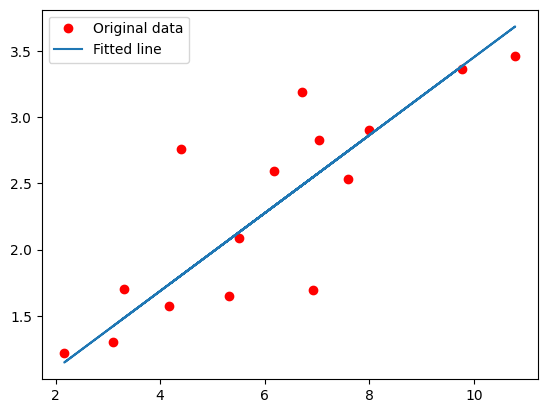

In [6]:
predicted = model(torch.tensor(x_train)).detach().numpy()
plt.plot(x_train, y_train, 'ro', label='Original data')
plt.plot(x_train, predicted, label='Fitted line')
plt.legend()
plt.show()

## 内部パラメータの入手や更新について

dictでモデルが取り出せるが、モデルのパラメタを別途直接指定したい、個別に取り出したい等の場合は、`torch.nn.Parameter`オブジェクトを扱う

詳しくは「PyTorch-Advanced」で説明する

- `torch.nn.Parameter`クラスの`__init__`関数にtorchテンソルを指定することで、全体を設定できる

- 個別には次のようにする
  - `＜モデル名＞.＜レイヤー名＞.weight`プロパティに重みが指定できる
  - `＜モデル名＞.＜レイヤー名＞.baias`プロパティにバイアスが指定できる

- 既に述べた通り重みやバイアスといったパラメーターなどの`torch.nn.Module`全体の状態は、`＜モデル名＞.state_dict()`メソッドで取得できる
  - パラメーターを最適化で使う際は専用の取得方法があり、`＜モデル名＞.parameters()`メソッドで取得する

In [7]:
list(model.parameters())

[Parameter containing:
 tensor([[0.2942]], requires_grad=True),
 Parameter containing:
 tensor([0.5099], requires_grad=True)]

# PyTorchによる実装例(2) NNによる分類


## 分類の内容

scikit-learnに含まれるワイン分類データセットを用いて、PyTorchでワインの等級分けを行う

- このデータセットには、13個の特徴量が含まれている
- 出力は本来class_0, 1, 2の3種類であるが、今回はclass_0,1のみを判別するため2つ用いる
- その他は次のようなモデルを想定する
  - 入力層(x)は13個:（特徴量に等しい）
  - 隠れ層(fc1): 全結合
  - 出力層(fc2): 全結合
  - softmax層: 判定するラベル数と同数の2ノード
    - 確率が足して1になるように調整する
 - 出力 ラベル0と1の確率

このネットワーク図は次の通り
- 記述とこの図の対応がとれるように
- このモデルはあくまでも練習用で精度はダメダメなことに注意(50%程度)
- 課題で精度向上を行います(90%超え)

<img src="http://class.west.sd.keio.ac.jp/dataai/text/model1.png" width=500>

復習として、Softmax関数は、$d$次元のベクトル${\bf y} \in \mathbb{R}^d$が与えられたとき、各次元の値の合計が1になるように正規化する

- すなわち、確率分布のような出力を任意の実数ベクトルから作ることができる

- ${\bf y}$の$i$番目の次元を$y_i$と書くと，Softmax関数は次の通り

$$
p_i = \frac{e^{y_i}}{\sum_{j=1}^d e^{y_j}}
$$


## 前準備
`import torch`としてtorchを利用

基本これだけでよいが、プログラムの記述上省略したほうが簡潔でよい、わかりやすいといった観点から、下記は必須ではないが、定義して省略形で使えるように準備する場合もある
- `import torch.nn as nn`: nnでニューラルネットワーク関数を参照
- `import torch.nn.functional as F`： Fで活性化関数定義
- `import torch.optim as optim` ：optimで最適化関数定義
- `from torch.utils.data import DataLoader, TensorDataset` ：データローダ、データセット利用を簡略化

簡単にpython文法を復習する
- `import A.B`とすると、Aの中のBという機能を利用できる
  - この場合、使うたびにA.Bと名前を指定する
  - A全体を読み込むより、A.Bしか読み込まないためメモリ利用効率は向上するが、利用の便宜上は何も変わらない
  - そこで、`from A import B`とすると、読み込みもA.BのみでBとして利用できる
- as はエイリアス(別名定義)である
  - `import A.B as C`とすれば、Cという名前で当該機能を利用できる
- 両方まとめて`from A.B import C.D as E`とできる

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## 学習データの準備

scikit-learnをデータセット入手だけに利用する
- ワインのデータセット、およびデータセットから教師データとテストデータを分離する関数もscikit-learn提供の機能を利用する

In [9]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

pandasも利用する

In [10]:
import pandas as pd

### 学習データの読み込み

load_wineを用いてデータセットを読み込む

データの中身を煩雑だが確認する
- 13個の特徴点リストを含むデータセットである
- feature_namesは、13個の特徴点の名称を含むデータセットである
- targetは、dataそれぞれがどのワイン種別に属するかを表している正解ラベルである
- target_namesはワインのラベルで、class_0、 class_1といった等級分けである


In [11]:
wine = load_wine()
wine

{'data': array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
         1.185e+03],
        ...,
        [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
         8.350e+02],
        [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
         8.400e+02],
        [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
         5.600e+02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

pandasのDataFrameを用いて、feature_namesをラベルとしてデータを表示する
- 中身をよりわかりやすく確認できる

In [12]:
pd.DataFrame(wine.data, columns=wine.feature_names)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


次に、2のラベルがついているデータを省いて、0と1だけにする

今回利用するデータが、たまたまクラスが0, 1, 2の順に並んでいるため、下記のようにすれば十分であるが、これでは汎用性がない

In [13]:
wine_data2 = wine.data[0:130]
wine_target2 = wine.target[0:130]

今後のことも考え、pandasのdropを用い、より汎用性の高い方法で分離する

`pandas.DataFrame.drop(labels=None,axis=0,index=None,columns=None,level=None,inplace=False,errors=’raise’)`

とする

各パラメータは次の通り

- labels: ラベル名またはラベル名のリスト
  -  (省略可能)初期値None  
  -  消去したい列データor行データのラベルを指定
- axis: 0または`index`,1または`columns`
  -  (省略可能)初期値0  
  -  行データ(0または`index`)を削除するか列データ(1または`columns`)を削除するかを指定
- index,columns: ラベル名またはラベル名のリスト
  - (省略可能)初期値None  
  - 省略したいラベル名を行データ(index)、列データ(columns)で個別に指定
- level: intもしくは階層名
  -  (省略可能)初期値None  
  -  ラベルとして利用する階層を指定
- inplace: bool値
  - (省略可能)初期値False  
  - Trueでvoidとなり元データに変更を反映
- errors:	`ignore`または`raise`
  - (省略可能)初期値’raise’  
  - ‘ignore’でエラーを無視し処理続行

教師データ、正解ラベルの両方からclass2のデータを消す必要があるため、一度データをマージして削除する

ここでは、横方向に連結して、第0列が正解ラベル、第1列以降に特徴量データが並ぶようにデータセットを構成する

- データの連結には`pd.concat([df1, df4], axis=1)`とする
  - 横方向に連結するため axis=1 を指定
  - このとき紐付けは 連結方向でないラベル=index について行われる
  - 連結方向のラベルにあたる columns はそのまま維持される

pd.concat([wine.data,wine.target], axis=1)としたいところだが、型が合わないといわれるので変換する
- 暗黙でやれといいたい
- ラベルが勝手につくと厄介なので、ここでラベルを付けておく

In [14]:
wine_cat = pd.concat([pd.DataFrame(wine.data, columns=wine.feature_names),
                      pd.DataFrame(wine.target, columns=['class'])], axis=1)
wine_cat.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


結合できたので、ここから、クラス2のデータを削除する

消す前に、練習として、classが2であるデータだけ抽出するには、次のようにする

In [15]:
wine_cat[wine_cat['class'] == 2].head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
130,12.86,1.35,2.32,18.0,122.0,1.51,1.25,0.21,0.94,4.10,0.76,1.29,630.0,2
131,12.88,2.99,2.40,20.0,104.0,1.30,1.22,0.24,0.83,5.40,0.74,1.42,530.0,2
132,12.81,2.31,2.40,24.0,98.0,1.15,1.09,0.27,0.83,5.70,0.66,1.36,560.0,2
133,12.70,3.55,2.36,21.5,106.0,1.70,1.20,0.17,0.84,5.00,0.78,1.29,600.0,2
134,12.51,1.24,2.25,17.5,85.0,2.00,0.58,0.60,1.25,5.45,0.75,1.51,650.0,2


あとで削除したときにどれだけ削除したかわかるように、データのサイズも確認しておく

In [16]:
wine_cat.shape

(178, 14)

実際にデータを削除する
- これには、dropメソッドを使う
- 先に示したように、データはインデックスを使って選択が可能で、dropは該当したデータだけ削除する
- inplace=Trueとして、結果を易直接wine_catに代入する

In [17]:
wine_cat[wine_cat['class']==2].index

Index([130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177],
      dtype='int64')

In [18]:
wine_cat.drop(wine_cat[wine_cat['class'] == 2].index, inplace=True)

行を抽出するのではなく列を抽出するため、`[:,:13]`となる
- 13であるが、これは0から12を意味する
  - 0から13個の情報、未満と解釈してもよい

In [19]:
wine_data = wine_cat.values[:,:13]
wine_target = wine_cat.values[:,13]
print(wine_data, len(wine_data))
print(wine_target, len(wine_target))

[[1.423e+01 1.710e+00 2.430e+00 ... 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 ... 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 ... 1.030e+00 3.170e+00 1.185e+03]
 ...
 [1.179e+01 2.130e+00 2.780e+00 ... 9.700e-01 2.440e+00 4.660e+02]
 [1.237e+01 1.630e+00 2.300e+00 ... 8.900e-01 2.780e+00 3.420e+02]
 [1.204e+01 4.300e+00 2.380e+00 ... 7.900e-01 2.570e+00 5.800e+02]] 130
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 130


### データセットの分割

データセットから取り出した特徴量XおよびラベルYについて、さらに「トレーニング用」と「テスト用」のデータに分割する


In [20]:
Train_X, Test_X, Train_Y, Test_Y = train_test_split(wine_data, wine_target, test_size=0.25)

内容を確認する130$\times$0.25$\approx$33である。

In [21]:
Train_X.shape, Test_X.shape

((97, 13), (33, 13))

### PyTorchテンソルへの変換と訓練データセット作成

from_numpyを使って変換(こちらはよくありますが古い書き方です)

In [22]:
train_X = torch.from_numpy(Train_X).float()
train_Y = torch.from_numpy(Train_Y).long()
test_X = torch.from_numpy(Test_X).float()
test_Y = torch.from_numpy(Test_Y).long()

torch.tensorを使って変換

In [23]:
train_X = torch.tensor(Train_X, dtype=torch.float)
train_Y = torch.tensor(Train_Y, dtype=torch.long)
test_X = torch.tensor(Test_X, dtype=torch.float)
test_Y = torch.tensor(Test_Y, dtype=torch.long)

今風かつ推奨の書き方

In [24]:
train_X = torch.FloatTensor(Train_X)
train_Y = torch.LongTensor(Train_Y)
test_X = torch.FloatTensor(Test_X)
test_Y = torch.LongTensor(Test_Y)

中身を確認

In [25]:
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

(torch.Size([97, 13]),
 torch.Size([33, 13]),
 torch.Size([97]),
 torch.Size([33]))

学習には、TensorDatasetを用いて一つのテンソルの中に入れる必要がある

In [26]:
train = TensorDataset(train_X, train_Y)

中身を確認する

In [27]:
train[0], len(train)

((tensor([1.2080e+01, 1.1300e+00, 2.5100e+00, 2.4000e+01, 7.8000e+01, 2.0000e+00,
          1.5800e+00, 4.0000e-01, 1.4000e+00, 2.2000e+00, 1.3100e+00, 2.7200e+00,
          6.3000e+02]),
  tensor(1)),
 97)

この train は TensorDataset であり，ミニバッチを生成するイテレータは DataLoader である

In [28]:
type(train)

torch.utils.data.dataset.TensorDataset

## 学習

学習の流れは次の通り
- ネットワーク構成図を再掲して説明する

<img src="http://class.west.sd.keio.ac.jp/dataai/text/model1.png" width=500>

- 順伝搬で出力を計算(図中①を求める)
- 出力値と正解ラベルから誤差を計算(図中②の計算)
- 重みによる誤差の偏微分値を計算(図中③の計算)
- 誤差を逆伝搬(図中④の計算)
- 更新した重みで500エポック計算

実装として、まずデータセットを準備し、次にネットワークを構成する

### データローダの構築

訓練データセットからミニバッチで順にデータを学習する
- ミニバッチではデータをミニバッチサイズ分まとめて並列的に学習させるため、入力させるデータの次元が一つ増えてミニバッチサイズ分束ねたテンソルとなる
  - PyTorchでは、入力される方(モデル)も対応して束ねたテンソルを受け付けることができるようになる
  - 自動化されているのでサイズなどは気にせずともよいが、込み入ると気にしないといけない場合もある
- ここでは、バッチサイズを15とする
  - この値はかなり小さく、モデルにもよるがGPUなら100を超えてもよい
- shuffle=Trueとしてでたらめに並び替える
  - shuffleは、取り出すたびにランダムに取り出すのではない
  - まずデータをシャッフルして、その後順に取り出す、全てが取り出し終わったらもう一度シャッフルしてデータを作り直す、という処理が行われる
    - 同じデータをエポック内で選択することがないということ
  - 訓練データは普通Trueを指定
    - ミニバッチとなるセットを、毎回異なるようにする

In [29]:
train_loader = DataLoader(train, batch_size=15, shuffle=True)

### モデル定義

ネットワークモデルを構築する

PyTorchでは通常、既に存在するクラスを継承して利用する

- `__init__`は、インスタンス生成時に呼ばれるコンストラクタ(1)
- superは継承元の親クラスを意味し、その親クラスのコンストラクタを呼び出す(2)
- nn.Linierでは、全結合層を構成
  - 入力の数を13、中間層のノード数を128と指定し、2層とする(3)
- さらに、128入力2出力の全結合層を構成(4)
- 次に、ネットワークにデータを通して出力値を求める関数を作成
  - 名前はforwardとする必要がある(5)
- fc1, fc2の活性化関数に例としてReLUを利用(6)
- その結果を次のfc3に投入(7)
- 値を返す(8)
  - 本来は最後にsoftmax関数を配置するが、次のノートブックで説明するようにPyTorchのCrossEntropyLoss処理はsoftmax処理も内包しているため、この場合softmax関数は不要
  - もしここでSoftmaxを指定する場合は、どの軸に対してsoftmaxを施すかを指定するためdim=0とする
    - 各自試すと良いが、誤ってsoftmaxを指定した場合でも、学習に失敗するといったことはないであろう
  - 結果を出力するため、戻り値をreturnする

In [30]:
class Net(nn.Module):
  def __init__(self): #(1)
    super(Net, self).__init__() #(2)
    self.fc1 = nn.Linear(13, 2) #(3)
    self.fc2 = nn.Linear(2, 2) #(4)
  def forward(self, x): #(5)
    x = F.relu(self.fc1(x)) #(6)
    x = self.fc2 (x) #(7)
    return x #(8)

インスタンス化してmodelを作成する
- このmodelにデータを投入する

In [31]:
model = Net()

最後に、ロス関数を設定する
- 今回は交差エントロピーを利用
- また、確率的勾配効果法SGDを利用して最適値へと漸近させる

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

### 学習の実行

今回は500回エポックを廻す
- 損失を格納する変数を0で初期化しておく(1)
- ミニバッチからデータを順次取り出して、train_xとtrain_yに格納する(2)  
- 初期勾配を0にする(3)
- 図の①に相当するforward計算を行う。これには、modelにtrain_xを渡せばよい(4)
- 図の②に相当する損失計算を行う。すでに宣言したcriterionに、計算結果と教師データを渡す(5)
- 図の③に相当する処理として、ロスを後方に伝搬させる(6)
- 図の④に相当する処理として、その結果を用いてパラメータを更新する(7)
- 毎回のlossの値を積算する(8)
- 10回に一度結果を表示して確認する。epochは0スタートであることに注意する(9)

In [33]:
for epoch in range(500):
  total_loss = 0 #(1)
  for train_x, train_y in train_loader: #(2)
    optimizer.zero_grad() #(3)
    output = model(train_x) #(4)
    loss = criterion(output, train_y) #(5)
    loss.backward() #(6)
    optimizer.step() #(7)
    total_loss += loss.data #(8)
  if(epoch+1)%10 == 0: #(9)
    print(epoch+1, total_loss)

10 tensor(4.9106)
20 tensor(4.8687)
30 tensor(4.7658)
40 tensor(4.8382)
50 tensor(4.8328)
60 tensor(4.7671)
70 tensor(4.8685)
80 tensor(4.8438)
90 tensor(4.8414)
100 tensor(4.8421)
110 tensor(4.8055)
120 tensor(4.8635)
130 tensor(4.7884)
140 tensor(4.7885)
150 tensor(4.8228)
160 tensor(4.7889)
170 tensor(4.7895)
180 tensor(4.7881)
190 tensor(4.8054)
200 tensor(4.8237)
210 tensor(4.7892)
220 tensor(4.7729)
230 tensor(4.8055)
240 tensor(4.8230)
250 tensor(4.7885)
260 tensor(4.7883)
270 tensor(4.8063)
280 tensor(4.8054)
290 tensor(4.8227)
300 tensor(4.7898)
310 tensor(4.7886)
320 tensor(4.8225)
330 tensor(4.7892)
340 tensor(4.8075)
350 tensor(4.8232)
360 tensor(4.7552)
370 tensor(4.8058)
380 tensor(4.8057)
390 tensor(4.8238)
400 tensor(4.7889)
410 tensor(4.8065)
420 tensor(4.7886)
430 tensor(4.7881)
440 tensor(4.7883)
450 tensor(4.7889)
460 tensor(4.7539)
470 tensor(4.8236)
480 tensor(4.7884)
490 tensor(4.8231)
500 tensor(4.8609)


## 精度の計算
まず値を取り出して、testに対する答えを出す
- `.detach`で出力含まれる勾配の演算情報を削除する


In [34]:
test_model = model(test_X).detach()

その結果の大きい方を予測結果とする
- test_yのデータと比較して、等しければ1、違っていれば0とし、全部足し合わせる
- その値を、データの総数で割り、平均正答率を求める

In [35]:
test_model

tensor([[-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732],
        [-0.3034, -0.0732]])

この行列は、それぞれのtestに対する評価値を保存している
- クラス0と考えられる値および、クラス1と考えられる値のセットである

値の大きい方が「推定した答え」であるので、こちらを選別する
- このように行列で値の大きい方をまとめて選別する特別な関数 torch.maxが準備されている

まずは、torch.maxについて簡単に説明する

### torch.maxについて

次の点を確認しよう

- モデルの出力はデータ数$\times$クラス数の行列である
- 正解データはデータ数次元のベクトルである

これら、モデルの出力と正解データを比較するためには、モデルの出力を正解データ同様に推定ラベルのデータ数次元のベクトルにしなければならない

このために利用するのがtorch.maxである
- データ数$\times$クラス数の行列の結果を、データ数の推定クラス番号の行列に変換する

torch.maxは、行列（ベクトル）の最大値とそのインデックスを返す

以下の例で確認する

|  |  |  |
|--|--|--|
|0.2|	1.4|	1.7|
|0.3|	1.5|	0.7|
|1.1|	1.3|	0.4|
|0.9|	2.3|	0.5|

このような例について、考えてみると、

縦で見れば、0.2, 0.3, 1.1, 0.9で最もスコアが高いのは1.1であるため第2行つまり2が選択され、他も同様に選択されることで、結果として$[2, 3, 0]$が得られる

torch.maxの戻り値は配列の配列であり、値で取得するのか、行もしくは列番号で取得するのかなどが指定できる

下記のセルで答えが一致することを確認しよう
- まずは、無理やり上記の行列を評価可能なテンソル型にする
  - このような変換はPyTorchを利用する上で極めて重要であるため慣れておくこと
  - 形違いのエラーを見たら、何をすべきかわかるようにしておく
  - なので、あえて型を変換せずに渡したり、別の型を与えたりして、エラーメッセージを確認しておくとよい

その後、torch.maxで最大を抽出する
- 行・列どちらで判断するかを0か1で指定する
- 0を指定すると列、1を指定すると行でみて最大値を取り出す


In [36]:
import numpy as np
testX = np.array([[0.2, 1.4, 1.7],[0.3, 1.5, 0.7],[1.1, 1.3, 0.4],[0.9, 2.3, 0.5]])
x = torch.tensor(testX, requires_grad=False, dtype=torch.float) # 新しい書き方に修正しています
print(x)
value, index = torch.max(x.data, 0)
print("value0:", value, "index0:", index)
value, index = torch.max(x.data, 1)
print("value1:", value, "index1:", index)

tensor([[0.2000, 1.4000, 1.7000],
        [0.3000, 1.5000, 0.7000],
        [1.1000, 1.3000, 0.4000],
        [0.9000, 2.3000, 0.5000]])
value0: tensor([1.1000, 2.3000, 1.7000]) index0: tensor([2, 3, 0])
value1: tensor([1.7000, 1.5000, 1.3000, 2.3000]) index1: tensor([2, 1, 1, 1])


さて、本題にもどって最大を抽出する

In [37]:
torch.max(test_model, 1)

torch.return_types.max(
values=tensor([-0.0732, -0.0732, -0.0732, -0.0732, -0.0732, -0.0732, -0.0732, -0.0732,
        -0.0732, -0.0732, -0.0732, -0.0732, -0.0732, -0.0732, -0.0732, -0.0732,
        -0.0732, -0.0732, -0.0732, -0.0732, -0.0732, -0.0732, -0.0732, -0.0732,
        -0.0732, -0.0732, -0.0732, -0.0732, -0.0732, -0.0732, -0.0732, -0.0732,
        -0.0732]),
indices=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1]))

なお、類似の関数にtorch.argmaxも準備されている
- 違いはアルゴリズムで、argmaxの方が計算速度を速くすることができるが、同じデータが並んでいた場合、torch.maxは必ず最初の要素を返すのに対して、argmaxは最初の値を返す保証がなくなるという問題がある
- torch.argmaxは最大値を与えることはできず、最大であるindexのみ返す

値が確認できたら、精度を求める

In [38]:
result = torch.max(test_model, 1)[1]
accuracy = sum(test_Y.data.numpy() == result.numpy()) / len(test_Y.data.numpy())
accuracy

np.float64(0.5151515151515151)

## 結果の確認

プログラムが実行できたからと言って安心してはいけない

以下の手順を実際に修正しながら動作を確認すること

状況を確認する

- test_modelの内容が、すべて同じ値になっている
  - これは、ワインの判定において、全て赤、もしくはすべて白と判定していることを意味する
  - 通常、極端に赤が多い、もしくは白が多いデータセットを用いたときに発生するが、今回はそのようなことはない
- 今回は、学習率が大きすぎるため、最適解付近で振動していると考えられる
  - 学習率を0.001にする
- 実行してみよう
  - これで、60%程度は達成する
- 次に、ネットワークを拡張してみよう
  - 以下の課題1にトライしてみよう

さらなる工夫を検討する
- 入力値について、それぞれ値の範囲がかなり異なる
  - 変化の大きな値に、学習において引っ張られる傾向がある
  - 特にネットワークが小さい場合は影響を受けやすい

- 入力値をすべて、例えば-1から1に正規化する
  - 以下の課題2にトライしてみよう

In [39]:
from sklearn.preprocessing import StandardScaler
Train_X, Test_X, Train_Y, Test_Y = train_test_split(
    wine_data, wine_target, test_size=0.25, stratify=wine_target
)
scaler = StandardScaler()
Train_X = scaler.fit_transform(Train_X)
Test_X  = scaler.transform(Test_X) # Train_Xで利用したスケールを再利用する

# 課題1(PyTorch NN改良)

ワイン分類の精度90%超えを狙いなさい

ヒントとして、次の点を改良してみよう

**[改良1]** Learning Rate (lr)の値を、既に確認した、より小さい値でにしなさい
- `optim.SGD(model.parameters(), lr=0.01)`のlrの値を指す
- 小さい値にすると学習速度の低下を招く場合があることも認識しておくこと

**[改良2]** 次のネットワークの改善の方で同様にパラメータを調整

- 例えば、ネットワークを以下のように変更し、隠れ層をさらに深く、全結合層を5層に増やす

<img src="http://class.west.sd.keio.ac.jp/dataai/text/model2.png" width="70%">

以下、モデルの再定義例を示す
- 各自でaccuracyの値を確認しなさい

In [40]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(13, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 128)
    self.fc4 = nn.Linear(128, 128)
    self.fc5 = nn.Linear(128, 128)
    self.fc6 = nn.Linear(128, 2)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = self.fc6(x)
    return x

# 課題2(PyTorch NN改良)

さらに次の点を改良してみよう

入力値について、それぞれ値の範囲がかなり異なるため、変化の大きな値に、学習において引っ張られる傾向がある
- 特にネットワークが小さい場合は影響を受けやすい

そこで、全ての値を-1から1に正規化する

次のコードを参考にするとよい
- このコードを適切な位置に挿入して効果を確認しなさい


In [41]:
from sklearn.preprocessing import MinMaxScaler
Train_X, Test_X, Train_Y, Test_Y = train_test_split(
    wine_data, wine_target, test_size=0.25, stratify=wine_target
)
scaler = MinMaxScaler(feature_range=(-1, 1))
Train_X = scaler.fit_transform(Train_X)
Test_X  = scaler.transform(Test_X)

# PyTorchによる実装例(3) 手書き文字認識

シンプルなディープラーニングを用いた手書き文字認識の例を示す

- 手書き文字認識といえば、MNISTが定番であるが、ここではさらに簡便なscikit-learnに付属する手書き文字データセットの認識を行う
- PyTorchにもMNISTデータセットが準備されているが、これはCNNの章で取り上げるとして、ここはさらに小規模なscikit-learnのMNISTを用いる
  - scikit-learnを用いた場合と比較するとよい
- 高々3層なのでディープといえるかどうかは微妙だが…

scikit-learnから、手書き数字の画像データを読み込んで表示する

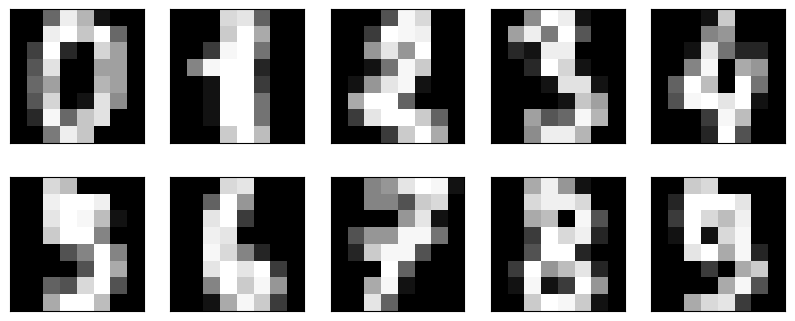

データの形状: (1797, 64)
ラベル: [0 1 2 3 4 5 6 7 8 9]


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
digits_data = datasets.load_digits()
n_img = 10  # 表示する画像の数
plt.figure(figsize=(10, 4))
for i in range(n_img):
  ax = plt.subplot(2, 5, i+1)
  plt.imshow(digits_data.data[i].reshape(8, 8), cmap="Greys_r")
  ax.get_xaxis().set_visible(False)  # 軸を非表示に
  ax.get_yaxis().set_visible(False)
plt.show()
print("データの形状:", digits_data.data.shape)
print("ラベル:", digits_data.target[:n_img])

画像サイズが8×8と小さい、つまり解像度が低いため、つぶれた画像になっている
- より解像度の高い画像の認識については改めて学びます
- 例として、0から9までの手書き数字の画像を表示したが、この程度の解像度しかない

このような手書き数字の画像が、scikit-learnの手書き文字データセットには1797枚含まれている
- 各画像は正解となる描かれた数字を表すラベルとセットになっている


scikit-learnのtrain_test_splitを使って、データを訓練用とテストに分割する
- 本来はこのような方法を選択しないが、scikit-learnのデータセットを利用するため、scikit-learnの流儀に従って無理やり使ってみる
- 効率を考えなければ、どのようにしても大丈夫であることを確認する

In [43]:
import torch
from sklearn.model_selection import train_test_split
digit_images = digits_data.data
labels = digits_data.target
x_train, x_test, t_train, t_test = train_test_split(digit_images, labels)  # 25%がテスト用
# PyTorchで扱うためTensorに変換
x_train = torch.tensor(x_train, dtype=torch.float32)
t_train = torch.tensor(t_train, dtype=torch.int64)
x_test = torch.tensor(x_test, dtype=torch.float32)
t_test = torch.tensor(t_test, dtype=torch.int64)

`nn`モジュールの`Sequential`クラスによりモデルを構築する
- 今回も、あまり精度の良いモデルではない
- 低解像度の画像は、ある意味畳み込み層やプーリング層を介した結果の画像ともいえなくもない

In [44]:
from torch import nn
net = nn.Sequential(
  nn.Linear(64, 32),  # 全結合層
  nn.ReLU(),          # ReLU
  nn.Linear(32, 16),
  nn.ReLU(),
  nn.Linear(16, 10)   #0から9の10種の数字に対応
)
net

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)

学習として、モデルを訓練する

- 損失関数に交差エントロピー誤差を用い、最適化アルゴリズムにSGD(確率的勾配降下法)を用いる
- 引数に構築したネットワーク(net)のパラメータを渡す
- 順伝播は訓練データ、テストデータ両者で行い誤差を計算する
- 訓練データについてのみ、逆伝播により$w$や$b$を`step`メソッドで更新する
- 今回はバッチ学習で全部のデータを入力して誤差を求める

なお、`lossfn = nn.CrossEntropyLoss()`として\
`loss_train = lossfn(y_train, t_train)`などとする例の方が一般的である

注意事項として、すでに述べた通り、softmaxが存在していないが、CrossEntropyがSoftmax+CrossEntropyであるため、softmaxを明示的に記述する必要はない

In [45]:
from torch import optim
# SGDを利用
optimizer = optim.SGD(net.parameters(), lr=0.01)  # 学習率は0.01
# 損失のログ
record_loss_train = []
record_loss_test = []
# 1000エポック学習
for i in range(1000):
  # 最初に勾配を初期化つまり0にする
  optimizer.zero_grad()
  # 順伝播
  y_train = net(x_train)
  y_test = net(x_test)
  # 交差エントロピー誤差で誤差を求める
  loss_train = nn.CrossEntropyLoss()(y_train, t_train)
  loss_test = nn.CrossEntropyLoss()(y_test, t_test)
  record_loss_train.append(loss_train.item()) # ゼロ次元テンソルからpythonの値を得るには.itemが便利
  record_loss_test.append(loss_test.item())
  # 逆伝播(trainのみ勾配を求める)
  loss_train.backward()
  # パラメータの更新
  optimizer.step()
  if i%100 == 0:
    print("Epoch:", i, "Loss_Train:", loss_train.item(), "Loss_Test:", loss_test.item())

Epoch: 0 Loss_Train: 2.5101816654205322 Loss_Test: 2.5268871784210205
Epoch: 100 Loss_Train: 0.8277267217636108 Loss_Test: 0.8430710434913635
Epoch: 200 Loss_Train: 0.4010128080844879 Loss_Test: 0.4223790168762207
Epoch: 300 Loss_Train: 0.25819095969200134 Loss_Test: 0.286259263753891
Epoch: 400 Loss_Train: 0.1929236501455307 Loss_Test: 0.22561074793338776
Epoch: 500 Loss_Train: 0.15528929233551025 Loss_Test: 0.1928994059562683
Epoch: 600 Loss_Train: 0.13062472641468048 Loss_Test: 0.17244993150234222
Epoch: 700 Loss_Train: 0.11282968521118164 Loss_Test: 0.15858900547027588
Epoch: 800 Loss_Train: 0.09932664781808853 Loss_Test: 0.14845778048038483
Epoch: 900 Loss_Train: 0.08859571814537048 Loss_Test: 0.14061473309993744


訓練データ、テストデータ両方の誤差の推移をグラフで表示する
どんどん誤差が低減しているのがわかるであろう

なお、追加で実行するとさらに削減できるが、削減幅はあまり期待できない

グラフを確認し、訓練データとテストデータの最終的な値がほぼ同じであることを確認する
- 異なる場合は過学習
- 同程度に誤差が大きい場合は学習不足

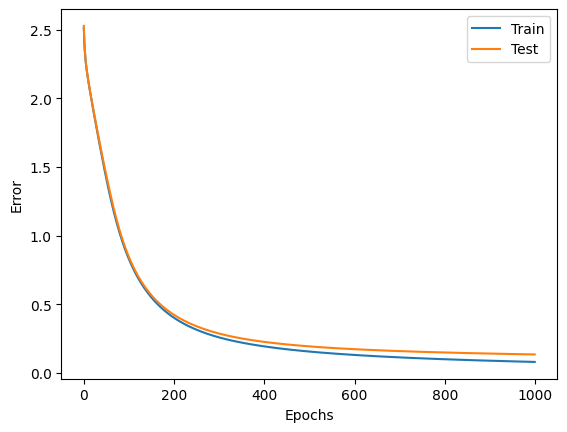

In [46]:
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()  # ラベルがあるときは、きちんとplt.show()を呼び出すこと

正答率を求めて、モデルの性能を確認する

ここでは、テストデータを用いる

In [47]:
y_test = net(x_test)
count = (y_test.argmax(1) == t_test).sum().item()
print("正解率:", str(count/len(y_test)*100) + "%")

正解率: 96.66666666666667%


訓練済みのモデルを使って、任意のデータを入力し、予測させる

実際に、`img_id`を変更して任意の画像を入力し、モデルが機能していることを確かめよう

- 間違いを探そうとすると確率5%程度なので、20回に1回しか成功しないであろう

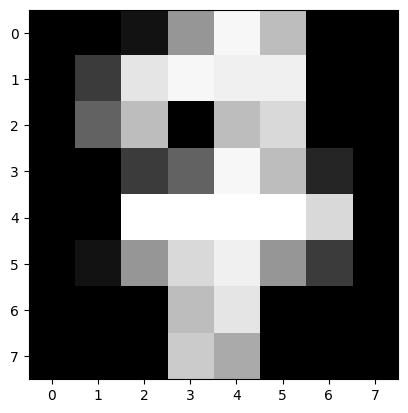

正解: 7 予測結果: 7


In [48]:
img_id = 17   # ここを好きな数字IDに変更するとよい
x_pred = digit_images[img_id]
image = x_pred.reshape(8, 8)
plt.imshow(image, cmap="Greys_r")
plt.show()
x_pred = torch.tensor(x_pred, dtype=torch.float32)
y_pred = net(x_pred)
print("正解:", labels[img_id], "予測結果:", y_pred.argmax().item())

In [49]:
y_pred

tensor([-4.5536,  1.1498, -3.4589,  1.4969,  5.2832, -2.5400, -5.2778,  8.4703,
         3.2707,  1.7015], grad_fn=<ViewBackward0>)

# 課題2(PyTorch MNIST)

scikit-learnの手書き文字認識データを使ったPyTorchによる認識について改良を施す

レポート条件
- 上記の例の結果を添付する
- 改良し、上記よりも少ないエポック数で、上記よりも良い結果を得るモデルを作成して添付する
- 改良は、下記の点に限定すること
  - 指定箇所以外の変更で性能を向上するとチート行為とみなされる
  - ただし、改良の意図や背景理論を一緒に記述してより良い結果を出している場合は、これを評価する

改良点(以下の改良点をすべて適用したコードを生成して実行すること)
- ネットワーク[改良点1]
  - 「ここから」「ここまで」の範囲を修正
  - 層の数や、層のノード数を変更するとよい
- 最適化アルゴリズム[改良点2]
  - 修正は1行とすること、複数行になってはいけない
- エポック数[改良点3]
  - 修正は数字だけにすること

下記コード中に、改良点を施す場所を記載しており、また、上記のオリジナルコードも記載しているので、[改良点1]、[改良点2]、[改良点3]の部分を変更して条件を満たすこと

提出方法はこれまでと同様とする

In [50]:
import torch
from sklearn import datasets
from sklearn.model_selection import train_test_split
digits_data = datasets.load_digits()
digit_images = digits_data.data
labels = digits_data.target
x_train, x_test, t_train, t_test = train_test_split(digit_images, labels)
x_train = torch.tensor(x_train, dtype=torch.float32)
t_train = torch.tensor(t_train, dtype=torch.int64)
x_test = torch.tensor(x_test, dtype=torch.float32)
t_test = torch.tensor(t_test, dtype=torch.int64)

## モデルの工夫[改良点1]

最初の64と最後の10さえ守れば大丈夫(なはず)

In [51]:
from torch import nn

net = nn.Sequential(
  # ここから「ここまで」のコードを変更すること
  nn.Linear(64, 32),  # 8x8の画像なので64からスタートするのは固定
  nn.ReLU(),
  nn.Linear(32, 16),
  nn.ReLU(),
  nn.Linear(16, 10)   #0から9の10種の数字に対応するので最後が10も固定
  # ここまで
)
net

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)

## 学習における最適化アルゴリズムの工夫[改良点2]

様々な最適化アルゴリズムが準備されている
- 学習した、しないに関わらず好きなモデルを使うと良い
- 次のwebページにマニュアルがあり各種最適化アルゴリズムが指定されている
  - https://pytorch.org/docs/stable/optim.html
  - 英語が嫌だという人へ、Googleの訳はこちら\
  https://translate.google.co.jp/translate?hl=ja&sl=en&tl=ja&u=https%3A%2F%2Fpytorch.org%2Fdocs%2Fstable%2Foptim.html

何してよいかわからないという人は、ひとまず学んだadamを使ってみてはどうだろう

- マニュアルにはadamだけでも様々存在するようだが、シンプルなadamが準備されている
  - もちろんハイパーパラメータもいろいろあるが、全部デフォルトでやってみるとよい
  - adamの威力を知れるであろう
  - ついでに、AMSGradの指定についても調べておくと良い\
  現時点で一般的に高性能とされるのが、AMSGradであろう
  




## エポック数の削減[改良点3]

[改良点1][改良点2]によりエポック数を削減しても、良い結果を得ることができるであろう

- 特に、[改良点2]の工夫はエポック数削減に大きく寄与し、現状のままでは過学習気味になるであろう

そこで、エポック数を削減し調整すること

Epoch: 0 Loss_Train: 5.7613091468811035 Loss_Test: 5.687485218048096
Epoch: 100 Loss_Train: 0.6950169801712036 Loss_Test: 0.769072413444519
Epoch: 200 Loss_Train: 0.3716047406196594 Loss_Test: 0.4962075352668762
Epoch: 300 Loss_Train: 0.24630588293075562 Loss_Test: 0.38328298926353455
Epoch: 400 Loss_Train: 0.18015484511852264 Loss_Test: 0.3238855004310608
Epoch: 500 Loss_Train: 0.13431794941425323 Loss_Test: 0.28303930163383484
Epoch: 600 Loss_Train: 0.10422677546739578 Loss_Test: 0.2534174919128418
Epoch: 700 Loss_Train: 0.08338836580514908 Loss_Test: 0.23147056996822357
Epoch: 800 Loss_Train: 0.06831517070531845 Loss_Test: 0.21446587145328522
Epoch: 900 Loss_Train: 0.057283367961645126 Loss_Test: 0.2021239846944809


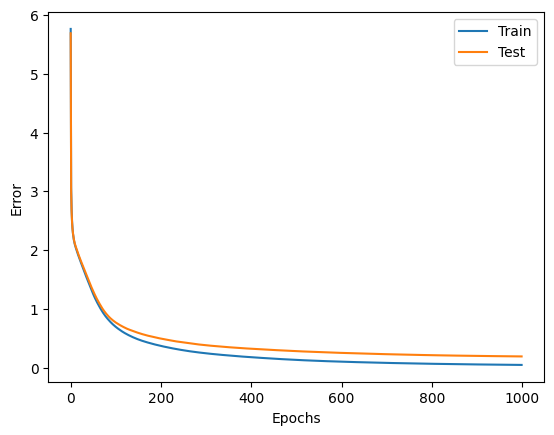

正解率: 93.77777777777779%


In [52]:
from torch import optim
# 次の部分は、何度実行しても「追加で学習」ではなく「最初から学習しなおし」になるように
# 詳細は省略しますが(学習が進むと説明があります)モデルのパラメータをXavier法で初期化しています
def init_weights(m):
  if isinstance(m, nn.Linear):
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)
net.apply(init_weights)
# 初期化されますので、今回はこのセルを何度実行しなおしても大丈夫です。
# 通常は、実行を繰り返すたび、エポックは戻らず、どんどん進んで過学習に向かいます
lossfn = nn.CrossEntropyLoss()
optimizer =  optim.SGD(net.parameters(), lr=0.01) #[変更点2] #Q2
record_loss_train = []
record_loss_test = []
for i in range(1000): #[変更点3] #Q3
  optimizer.zero_grad()
  y_train = net(x_train)
  y_test = net(x_test)
  loss_train = lossfn(y_train, t_train)
  loss_test = lossfn(y_test, t_test)
  record_loss_train.append(loss_train.item())
  record_loss_test.append(loss_test.item())
  loss_train.backward()
  optimizer.step()
  if i%100 == 0:
    print("Epoch:", i, "Loss_Train:", loss_train.item(), "Loss_Test:", loss_test.item())
import matplotlib.pyplot as plt
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()
y_test = net(x_test)
count = (y_test.argmax(1) == t_test).sum().item()
print("正解率:", str(count/len(y_test)*100) + "%")

今回の課題は、実際にロス曲線を記述するので、ロス曲線を見て判断することも練習してみよう

皆さんの結果は、上記のロス曲線と比較してどうだろうか？

- 改めて、普通はTESTデータつまり検証用データのロスが、TRAINデータつまり訓練用データのロスがよくなる(小さくなる)に伴ってよくなる(小さくなる)のですが、過学習状態になると途中で転じて良くなった後、また悪くなります
  - この場合、過学習にならないようにエポックを減らします
  - 上記の場合、過学習がみられないことから、エポック数も適切と判断できます

- また、上記は、訓練データも検証データも十分ロスが小さくなっているので、モデルは正解、と判断できますし、良い結果が期待できます
  - 学習データと訓練データに少しの差があるのは当然です
  - 極端に差が開いている場合は、モデルが学習用データに特化しすぎていることや、そもそもデータセットをうまく作ることができていないことが想定されます
  - 学習データでロスの値が小さいのに、訓練データがよくない場合は、モデルが学習データに合致しすぎて汎化性能が低下している、ということになります